In [9]:
%pip install --upgrade --quiet pandas scikit-learn seaborn catboost shap

Note: you may need to restart the kernel to use updated packages.


In [16]:
from catboost import CatBoostClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [17]:
df = pd.read_csv('data/learning_table.csv', sep=',')
df = df.drop(['target', 'sequence', 'date', 'obj_type', 'group'], axis=1)
print(df.head())
class_distribution = df['shifted_target'].value_counts()
print(class_distribution)

   coal_temp  temp_max  temp_mean  humidity_max  humidity_mean  precipitation  \
0       34.8      22.9  21.454167            90      84.875000            0.8   
1       31.2      22.7  22.220833            90      84.333333            0.9   
2       35.1      24.8  23.258333            91      81.041667            3.9   
3       33.2      27.0  24.983333            85      73.208333            0.0   
4       36.1      25.2  23.691667            72      58.708333            0.0   

      v_mean      v_max       p_mean   p_max  ...  autumn  shifted_target  \
0  12.891667  18.733333  1005.191667  1006.5  ...       0             0.0   
1  13.991667  19.979167  1008.475000  1010.6  ...       0             0.0   
2  14.400000  23.579167  1011.158333  1013.1  ...       0             0.0   
3  11.591667  16.400000  1013.237500  1013.7  ...       0             0.0   
4  22.812500  30.820833  1013.416667  1014.3  ...       0             0.0   

   coal_temp_rolling_mean  coal_temp_deviation  mo

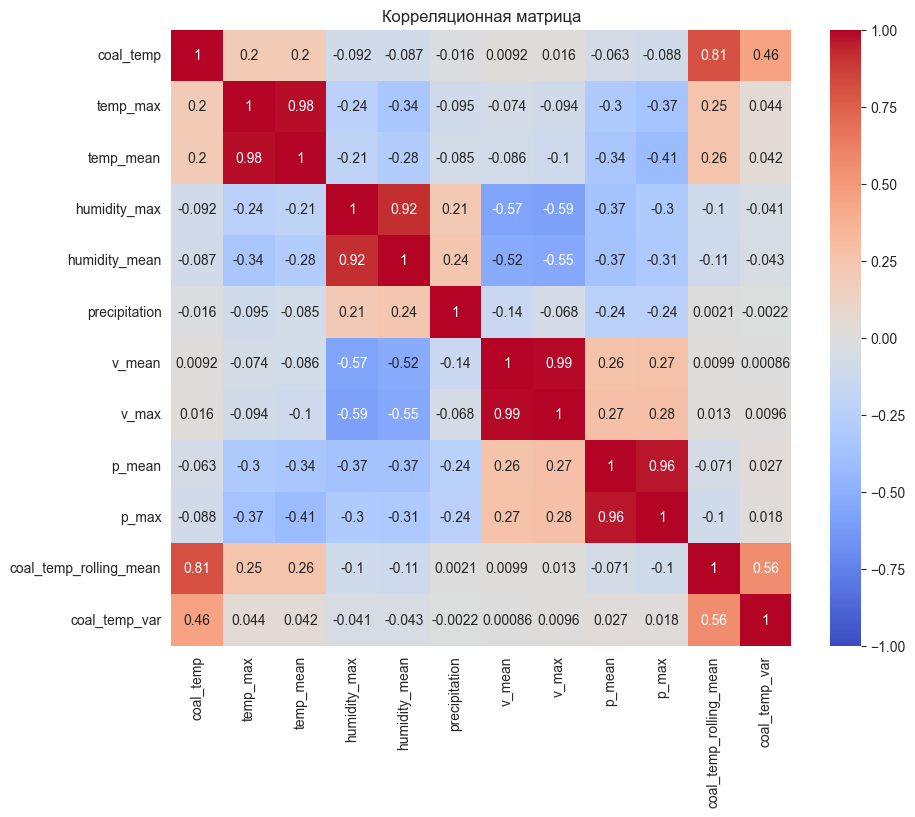

   coal_temp  temp_max  temp_mean  humidity_max  humidity_mean  precipitation  \
0       34.8      22.9  21.454167            90      84.875000            0.8   
1       31.2      22.7  22.220833            90      84.333333            0.9   
2       35.1      24.8  23.258333            91      81.041667            3.9   
3       33.2      27.0  24.983333            85      73.208333            0.0   
4       36.1      25.2  23.691667            72      58.708333            0.0   

      v_mean      v_max       p_mean   p_max  coal_temp_rolling_mean  \
0  12.891667  18.733333  1005.191667  1006.5                   34.80   
1  13.991667  19.979167  1008.475000  1010.6                   33.00   
2  14.400000  23.579167  1011.158333  1013.1                   35.10   
3  11.591667  16.400000  1013.237500  1013.7                   34.15   
4  22.812500  30.820833  1013.416667  1014.3                   34.80   

   coal_temp_var  
0         3.2400  
1         3.2400  
2         8.5321  
3   

In [18]:
X = df.drop(columns=['summer', 'spring', 'autumn', 'shifted_target', 'coal_temp_deviation', 'month'
                     ,'coal_temp_p_mean', 'coal_temp_lag2d', 'coal_temp_lag1d', 'coal_temp_lag3d'])
correlation_matrix = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,  # Показать значения в ячейках
    cmap='coolwarm',  # Цветовая схема
    vmin=-1, vmax=1  # Диапазон значений
)
plt.title('Корреляционная матрица')
plt.show()

print(X.head())
y = df.iloc[:, -9]
print(y.head())

In [19]:
# Предполагая, что X - фичи, y - целевая переменная (shifted_target)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,  # Для сохранения баланса классов
    random_state=42
)

In [20]:
model = CatBoostClassifier(
    iterations=1000,
    auto_class_weights="Balanced",  # Автоматическая балансировка
    eval_metric="F1",
    early_stopping_rounds=50,
    verbose=100
)
model.fit(X_train, y_train)

Learning rate set to 0.011065
0:	learn: 0.8685565	total: 1.94ms	remaining: 1.94s
100:	learn: 0.9230654	total: 67.8ms	remaining: 604ms
200:	learn: 0.9297341	total: 122ms	remaining: 485ms
300:	learn: 0.9373035	total: 172ms	remaining: 399ms
400:	learn: 0.9466595	total: 223ms	remaining: 333ms
500:	learn: 0.9493573	total: 274ms	remaining: 272ms
600:	learn: 0.9569779	total: 328ms	remaining: 218ms
700:	learn: 0.9653864	total: 379ms	remaining: 162ms
800:	learn: 0.9686013	total: 430ms	remaining: 107ms
900:	learn: 0.9741627	total: 482ms	remaining: 53ms
999:	learn: 0.9793170	total: 533ms	remaining: 0us


F1-score: 0.6851851851851852


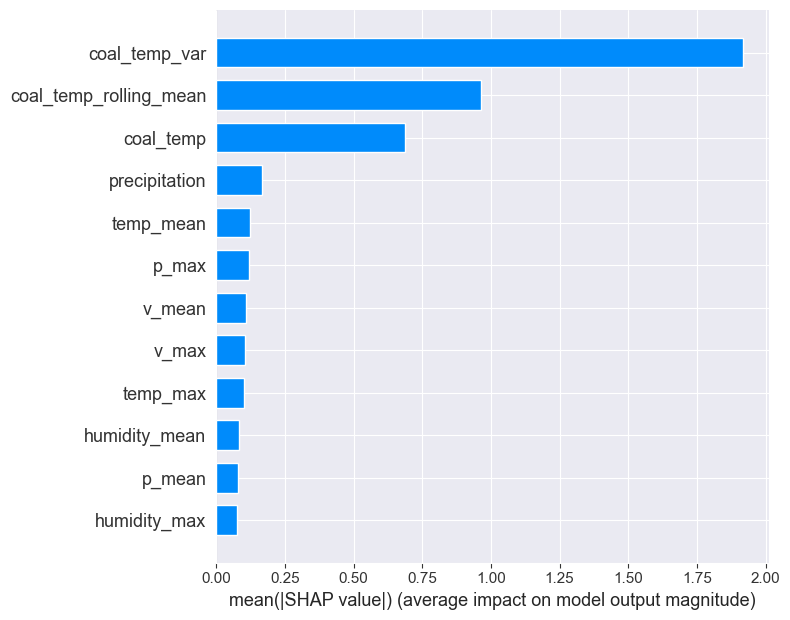

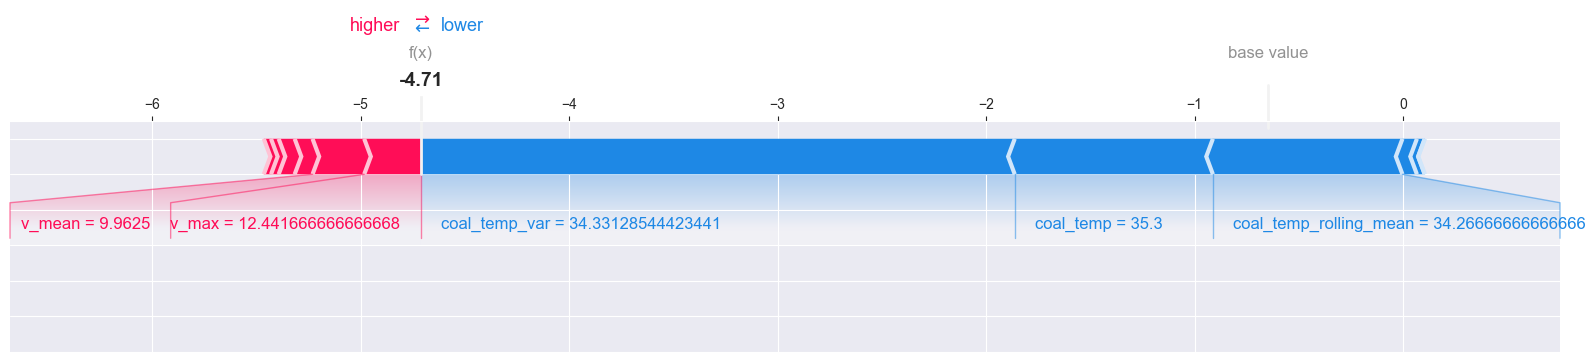

In [21]:
y_pred = model.predict(X_test)
print("F1-score:", f1_score(y_test, y_pred))

# SHAP-анализ
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Глобальная важность признаков
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Локальная интерпретация (для первого наблюдения)
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    X_test.iloc[0],
    matplotlib=True
)